**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [46]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

**Task 1:** Fit the iris dataset into a Perceptron layer and predict the class of a sample with length 2 and width 0.5. Use: 
'max_iter=1000', 'tol =1e-3' and 'random_state= 42'.





In [48]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)


In [51]:
#per_clf = 
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

#y_pred =
y_pred = per_clf.predict([[2, 0.5]])

 

In [53]:
y_pred

array([1])

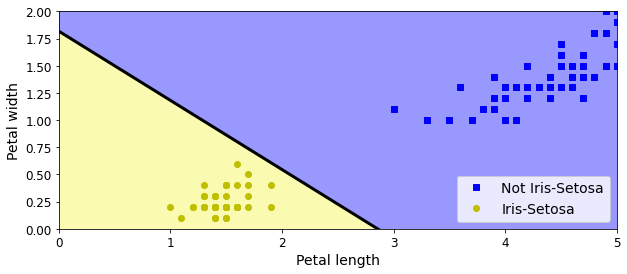

In [54]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

#save_fig("perceptron_iris_plot")
plt.show()

**Task 2:** Elaborate **in the report** on the difference between a perceptron and logistic regression.

Perceptron can be used with multiple activation functions which logistic regression makes use of the sigmoid.

# Activation functions

**Task 3:** Briefly describe **in the report** the role of activation functions within a neural network. What would be a neural network without these functions? 

An activation function are mathematical equations which determine the output of a neural network. It is attached to each neuron and decides whether it should be activated or not based on whether each neuron's output is relevant to model's prediction. 
Without an activation function a neural network is simply a linear regression model. 

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [55]:
import tensorflow as tf
from tensorflow import keras

In [56]:
tf.__version__

'2.4.1'

In [57]:
keras.__version__

'2.4.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [58]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [59]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [65]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [66]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

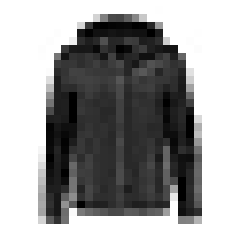

In [67]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [68]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [69]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [70]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [71]:
X_valid.shape

(5000, 28, 28)

In [72]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


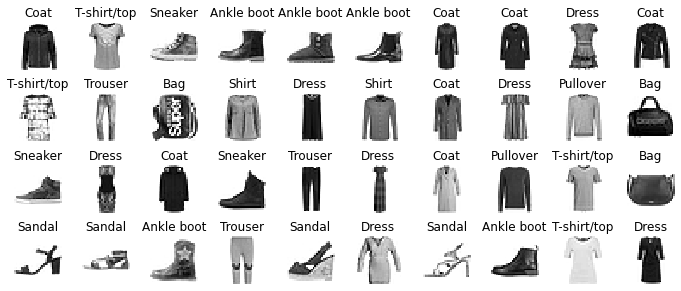

In [73]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

**Training a neural network using Keras:** In the cells below we  build an deep neural network model using Keras Sequential tool. The input is an image of shape 28 by 28. We use a network with 2 hidden layers with 300 and 100 neurons, respectively. The 'softmax' output activation function is used for multi-label classification.  

In [74]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


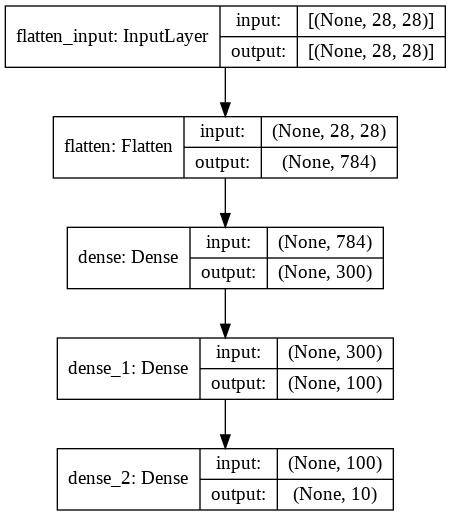

In [77]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [78]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [79]:
model.get_layer(hidden1.name) is hidden1

True

In [80]:
weights, biases = hidden1.get_weights()

In [81]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [82]:
weights.shape

(784, 300)

In [83]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [84]:
biases.shape

(300,)

**Compilation:** We compile the model using the "sparse_categorical_crossentropy" loss function and "accuracy" as metric for a multi-label classification task. In addition, we choose the "sgd" optimizer.

In [85]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

**Note:** Once compiled, we use model.fit to train the model for at least 30 epochs. 

We save the most crucial parameters (['loss', 'accuracy', 'val_loss', 'val_accuracy']) in a dictionary named "history". 

In [86]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0188 - accuracy: 0.6806 - val_loss: 0.5211 - val_accuracy: 0.8216
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5027 - accuracy: 0.8261 - val_loss: 0.4354 - val_accuracy: 0.8526
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4481 - accuracy: 0.8422 - val_loss: 0.5304 - val_accuracy: 0.8002
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4205 - accuracy: 0.8528 - val_loss: 0.3917 - val_accuracy: 0.8646
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4057 - accuracy: 0.8582 - val_loss: 0.3748 - val_accuracy: 0.8692
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3750 - accuracy: 0.8679 - val_loss: 0.3716 - val_accuracy: 0.8726
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3650 - accuracy: 0.8712 - val_loss: 0.3622 - val_accuracy:

In [87]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [88]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [89]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


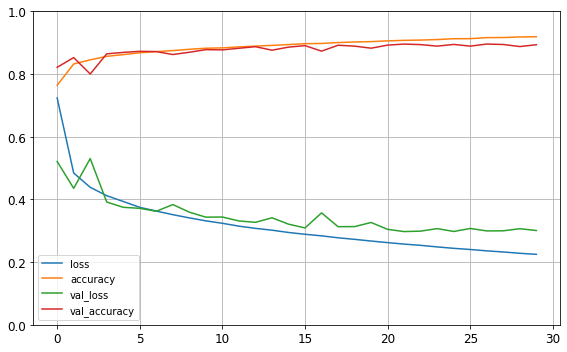

In [90]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

**Task 4:** Validate your model using model.evaluate on the test set made of X_test and y_test. 

In [92]:
# evaluate model on  test set
test_loss, test_acc = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3339 - accuracy: 0.8820


**Task 5:** Select the first three samples from the test set and predict their corresponding classes using model.predict_classes . Then print the names/categories of the elements in  question (Eg. "Pants", "trouser") 

In [93]:
X_new = X_test[:3]

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [94]:
#y_pred = 
y_pred=np.argmax(model.predict(X_new), axis=-1)
#y_pred

In [95]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


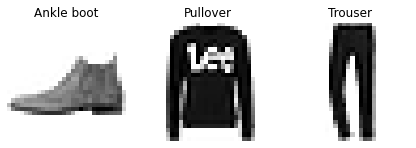

In [96]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

**Task 6:** Scale your training, validation and test feature matrices using scikitlearn's StandardScaler. (Dcoumentation and example on this [link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

In [97]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)


In [98]:
X_train.shape

(11610, 8)

In [102]:
X_train

array([[   3.5214    ,   15.        ,    3.04994451, ...,    1.60599334,
          37.63      , -122.43      ],
       [   5.3275    ,    5.        ,    6.49005964, ...,    3.44333996,
          33.69      , -117.39      ],
       [   3.1       ,   29.        ,    7.54237288, ...,    2.25084746,
          38.44      , -122.98      ],
       ...,
       [   1.5561    ,   35.        ,    4.13993174, ...,    3.27645051,
          34.11      , -117.29      ],
       [   2.1055    ,   52.        ,    5.17849462, ...,    2.92688172,
          36.76      , -119.79      ],
       [   5.6022    ,   31.        ,    6.21971253, ...,    2.53798768,
          38.04      , -122.2       ]])

In [104]:
#scaler = 
#X_train = 
#X_valid = 
#X_test = 
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_std=sc.fit_transform (X_train)
X_valid_std= sc.fit_transform (X_valid)
X_test_std= sc.fit_transform (X_test)

In [100]:
np.random.seed(42)
tf.random.set_seed(42)

**Task 7:** Build a Neural Network with one hidden layer with 30 neurons. The output layer has one neuron, which is the regression value. Compile, fit then train this network while choosing the suitable loss function and the SGD optimizer. 

**N.B:**  This task is similar to task 5 except that we now do regression not classification. 

In [113]:
#model = #


#...
#history = 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout


model = Sequential()
model.add(Dense(30,activation='relu',input_dim = 8))

#model.add(Dense(30,activation='relu'))

model.add(Dense(1))
model.compile(optimizer='sgd',loss='mse')
   



In [124]:
model.fit(x=X_train_std,y=y_train,
          validation_data=(X_valid_std,y_valid),
          batch_size=64,epochs=30)
model.summary()

Epoch 1/30
182/182 [==============================] - 1s 3ms/step - loss: 0.3807 - val_loss: 0.4500
Epoch 2/30
182/182 [==============================] - 0s 2ms/step - loss: 0.4004 - val_loss: 0.5099
Epoch 3/30
182/182 [==============================] - 0s 2ms/step - loss: 0.4781 - val_loss: 0.5192
Epoch 4/30
182/182 [==============================] - 0s 2ms/step - loss: 0.4297 - val_loss: 0.4322
Epoch 5/30
182/182 [==============================] - 0s 2ms/step - loss: 0.3717 - val_loss: 0.4289
Epoch 6/30
182/182 [==============================] - 0s 2ms/step - loss: 0.3686 - val_loss: 0.4464
Epoch 7/30
182/182 [==============================] - 0s 2ms/step - loss: 0.3686 - val_loss: 0.4275
Epoch 8/30
182/182 [==============================] - 0s 2ms/step - loss: 0.3658 - val_loss: 0.4315
Epoch 9/30
182/182 [==============================] - 0s 2ms/step - loss: 0.3642 - val_loss: 0.4307
Epoch 10/30
182/182 [==============================] - 0s 2ms/step - loss: 0.3630 - val_loss: 0.4181

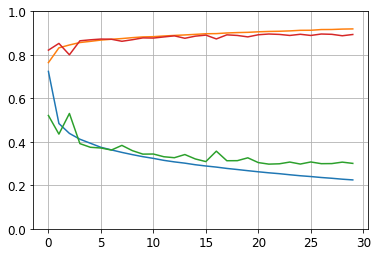

In [125]:
import matplotlib.pyplot as plt
import pandas as pd


plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Task 8:** Validate your model using model.evaluate on a test set. 

162/162 [==============================] - 0s 1ms/step - loss: 0.0000e+00
MAE: 0.4380028165279211
MSE: 0.383114274861725
RMSE: 0.6189622564112653
VarScore: 0.7160274219100047


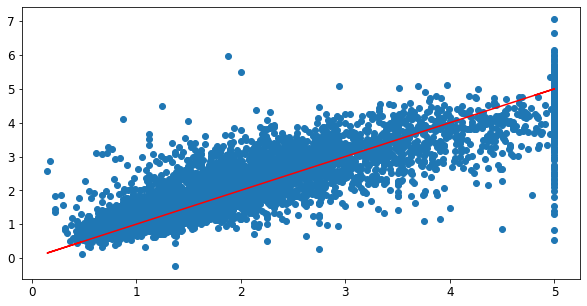

In [126]:
#mse_test = 
#X_new = 
#y_pred = '
X_new=model.evaluate(X_test_std)
y_pred = model.predict(X_test_std)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [127]:
y_pred=model.predict(X_test_std)

In [128]:
y_pred

array([[0.58052313],
       [1.7666162 ],
       [4.7991767 ],
       ...,
       [1.4204574 ],
       [2.4057264 ],
       [4.2501597 ]], dtype=float32)

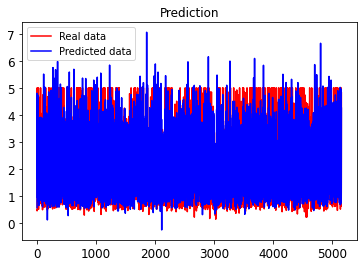

In [130]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

# Saving the model weights for future use

In [131]:
model.save("my_keras_model.h5")

In [132]:
model = keras.models.load_model("my_keras_model.h5")

In [133]:
model.predict(X_test_std)

array([[0.58052313],
       [1.7666162 ],
       [4.7991767 ],
       ...,
       [1.4204574 ],
       [2.4057264 ],
       [4.2501597 ]], dtype=float32)

In [134]:
model.save_weights("my_keras_weights.ckpt")

In [135]:
model.load_weights("my_keras_weights.ckpt")

# Optional task

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [138]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [139]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [140]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [141]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

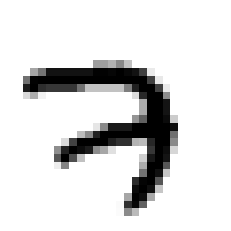

In [142]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [143]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [144]:
X_valid.shape

(5000, 28, 28)

In [145]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

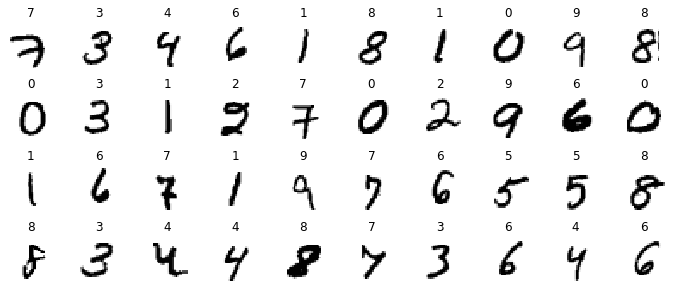

In [146]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

**Task 9:** Using the same methodology as earlier tasks, clear the session, set random seed to 42 and build a neural network with 2 hidden layers to classify MNIST images. 

In [169]:
#
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [170]:
#model =
model=Sequential()
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    
    keras.layers.Dense(10, activation="softmax")
])


In [171]:
# compile model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [172]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Now let's train the model for just 1 epoch:

In [173]:
#history =
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 4s 2ms/step - loss: 1.0483 - accuracy: 0.7216 - val_loss: 0.3103 - val_accuracy: 0.9120


In [174]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [175]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2954 - accuracy: 0.9154 - val_loss: 0.2434 - val_accuracy: 0.9324
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2424 - accuracy: 0.9307 - val_loss: 0.2114 - val_accuracy: 0.9408
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2080 - accuracy: 0.9407 - val_loss: 0.1805 - val_accuracy: 0.9490
Epoch 4/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1810 - accuracy: 0.9486 - val_loss: 0.1628 - val_accuracy: 0.9548
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1601 - accuracy: 0.9538 - val_loss: 0.1490 - val_accuracy: 0.9572
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1433 - accuracy: 0.9596 - val_loss: 0.1358 - val_accuracy: 0.9630
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1290 - accuracy: 0.9637 - val_loss: 0.1269 - val_ac

In [176]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0659 - accuracy: 0.9802


[0.06593554466962814, 0.9801999926567078]